### Initial Exploratory Data Analysis

In [1]:
%matplotlib inline 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams.update({'font.size': 14, 'axes.titlesize': 14,
                     'figure.titlesize': 14})

In [2]:
# Load datasets
sea_train = pd.read_csv('seattle_train_ft.csv')
sea_test = pd.read_csv('seattle_test_ft.csv')
sea_test.dropna(subset=['result'], axis=0, inplace=True)

In [3]:
# Add token for records with no focused_text
sea_train['focus_text'].fillna('unk', inplace=True)
sea_test['focus_text'].fillna('unk', inplace=True)

In [4]:
# Words that I stripped after later review in notebook
to_strip = {'pudding', 'sticky', 'healthy'}
for df in [sea_train, sea_test]:
    df['focus_text']
    df['focus_text'] = df['focus_text'].apply(lambda x : [e for e in x.split(' ') if e not in to_strip ])
    df['focus_text'] = df['focus_text'].apply(lambda x : ' '.join(x))

In [5]:
# Add feature for number of focused words
def count_ft(x):
    if x == 'unk':
        count = 0
    else:
        count = len(x.split(' '))
    return count
    
sea_train['num_ft'] = sea_train['focus_text'].apply(count_ft)
sea_test['num_ft'] = sea_test['focus_text'].apply(count_ft)

In [6]:
# Helper for plotting distributions and printing summary statistics
def dist_plotter(dist, bins=None, xlab='Value', ylab='Count', title=''):
    if bins is not None:
        plt.hist(dist, bins=bins)
    else:
        plt.hist(dist)
    plt.xlabel(xlab)
    plt.ylabel(ylab)
    plt.title(title)
    plt.show()
    print(f'Mean: {dist.mean():.3f}, Median: {dist.median():.3f}, Max: {dist.max():.3f}')

Now, I'll plot the distribution of reviews per sample and focused text tokens (including repeated words) for Seattle. 

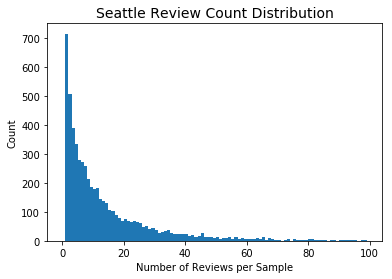

Mean: 14.960, Median: 8.000, Max: 278.000


In [7]:
dist_plotter(sea_train['num_reviews'], xlab='Number of Reviews per Sample', ylab='Count',
             title='Seattle Review Count Distribution', bins=range(0,100))

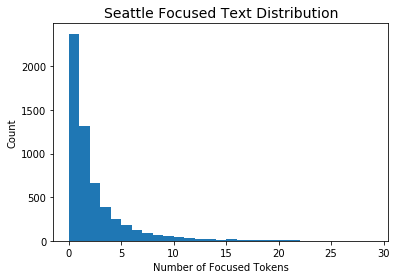

Mean: 1.925, Median: 1.000, Max: 67.000


In [8]:
dist_plotter(sea_train['num_ft'], xlab='Number of Focused Tokens', ylab='Count', title='Seattle Focused Text Distribution',
             bins=range(0,30))

I would also like to see the distribution of number of documents per word. For that, I can construct some binary count matrices. 

In [9]:
from sklearn.feature_extraction.text import CountVectorizer
sea_cvect = CountVectorizer(binary=True)
sea_ft_counts = sea_cvect.fit_transform(sea_train.focus_text)
sea_labeled_counts = dict(zip(pd.Series(sea_cvect.vocabulary_).sort_values().index.values, np.mean(np.array(sea_ft_counts.todense()), axis=0)))

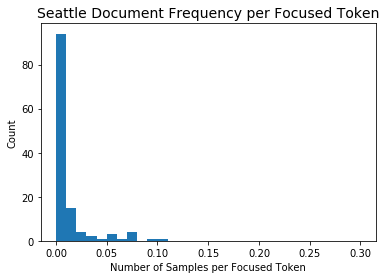

Mean: 0.012, Median: 0.004, Max: 0.106


In [10]:
# Note that 'unk' has been sliced out
dist_plotter(pd.Series(list(sea_labeled_counts.values())).sort_values()[:-1], xlab='Number of Samples per Focused Token',
             ylab='Count', title='Seattle Document Frequency per Focused Token', bins=np.linspace(0,0.3,31))

I am curious about which words are most frequent. This does show that a few words might be driving most of the occurences (ignore 'unk'). 

In [11]:
# Seattle top word counts
pd.Series(sea_labeled_counts).sort_values(ascending=False).head(11)

unk            0.415864
gross          0.106461
dirty          0.098932
shit           0.076869
raw            0.076519
sick           0.076169
hair           0.075643
disgust        0.068990
nasty          0.059184
mushy          0.055157
undercooked    0.052355
dtype: float64

In [12]:
# Seattle bottom word counts
pd.Series(sea_labeled_counts).sort_values(ascending=True).head(10)

vacuums         0.000175
contaminated    0.000175
bushes          0.000175
inspect         0.000525
bacteria        0.000525
scratches       0.000700
crud            0.000700
seagull         0.000700
unkept          0.000700
pesticides      0.000700
dtype: float64

'unk' is the stand-in for all of the samples without any focused text. The distribution is skewed right, so some words are much more common than others.

I am curious about why some reviews are extreme outliers in terms of having many of these terms. I will look manually at some examples.

In [13]:
for idx, row in sea_train.sort_values('num_ft', ascending=False).head(10).iterrows():
    print(f'num_ft: {row.num_ft}, result: {row.result}, num_reviews: {row.num_reviews}')
    print(f'focus text: \n{row.focus_text} \n')

num_ft: 67, result: 1.0, num_reviews: 180
focus text: 
filthy undercooked yuck artery grungy shit hygiene hygiene nasty slimy shit filthy gross filthy ick gross nasty yuck dirty flu scum shit dirty filthy disturbing toilet raw divey artery bin bin mushy filthy dirty raw filthy disgust filthy violation dirty dirty bin toilet filthy dirty dirty dirty disturbing sick meth dirty sick dirty shit gross dirty dirty sick gross dirty puke hair disgust gross gross artery unhealthy 

num_ft: 41, result: 0.0, num_reviews: 125
focus text: 
sick trashed crawled crawled dirty disgust gross sick toilet unkept disgust dirty dirty dirty dirty toilet bin contaminate disgust dirty sick grungy grungy ill dirty garbage disgust garbage gross hair hair hair hair dirty dingy grungy disgust dirty bug dirty artery 

num_ft: 36, result: 0.0, num_reviews: 121
focus text: 
toilet toilet dumpster toilet toilet ache raw toilet toilet toilet sick toilet toilet toilet toilet toilet toilet toilet toilet toilet toilet to

5 of 10 samples with the most focused text tokens failed, and 5 failures are expected from the dataset average. Some samples have a more diverse mixture of the focused tokens, while others are very repetitive. 

In addition, the samples with the most focused tokens are samples with far more than typical number of reviews. What about ratio of focused_text to number of reviews (a way of normalizing for the amount of text per samples)?

In [14]:
sea_train['ft_ratio'] = sea_train['num_ft'] / (sea_train['num_reviews'] + 1e-10)

In [15]:
for idx, row in sea_train.sort_values('ft_ratio', ascending=False).head(10).iterrows():
    print(f'ft_ratio: {row.ft_ratio:.2f}, result: {row.result:.3f}, num_reviews: {row.num_reviews:.3f}')
    print(f'focus text: \n{row.focus_text} \n')

ft_ratio: 6.00, result: 1.000, num_reviews: 1.000
focus text: 
headache dirty gross dirty grungy gross 

ft_ratio: 4.00, result: 0.000, num_reviews: 2.000
focus text: 
mold hair hair mold mold hair gross garbage 

ft_ratio: 3.50, result: 1.000, num_reviews: 2.000
focus text: 
ick hair hair ick yuck rancid mold 

ft_ratio: 3.33, result: 1.000, num_reviews: 3.000
focus text: 
hair hair hair hair hair hair hair hair disgust hair 

ft_ratio: 3.00, result: 0.000, num_reviews: 2.000
focus text: 
gross grime gross dirty yuck bug 

ft_ratio: 3.00, result: 1.000, num_reviews: 1.000
focus text: 
puke puke gross 

ft_ratio: 3.00, result: 0.000, num_reviews: 1.000
focus text: 
dirty dirty smelly 

ft_ratio: 3.00, result: 0.000, num_reviews: 1.000
focus text: 
hair hair hair 

ft_ratio: 3.00, result: 0.000, num_reviews: 1.000
focus text: 
gross ick cigarette 

ft_ratio: 3.00, result: 1.000, num_reviews: 1.000
focus text: 
inedible shit disturbing 



Again, 5 of the top 10 failed vs. 5 of 10 expected. However, looking at the number of reviews, it appears that, for the most part, a single bad review with no other reviews drives these reviews to the top. Therefore, this is a noisy metric to use. 

I'll now repeat with the same metric but set a minimum number of reviews and again look at the top 10. 

In [16]:
for idx, row in sea_train.loc[sea_train.num_reviews > 5].sort_values('ft_ratio', ascending=False).head(20).iterrows():
    print(f'ft_ratio: {row.ft_ratio:.2f}, result: {row.result:.3f}, num_reviews: {row.num_reviews:.3f}')
    print(f'focus text: \n{row.focus_text} \n')

ft_ratio: 2.00, result: 1.000, num_reviews: 11.000
focus text: 
nasty sick yuck filthy dirty junk filthy smelly dusty hair hair hair filthy filthy hair cigarette dumpster filthy hair nasty dirty gross 

ft_ratio: 1.71, result: 1.000, num_reviews: 7.000
focus text: 
hair cockroach cockroach dirty shit dusty dirty unsanitary dirty cockroach rat shit 

ft_ratio: 1.67, result: 1.000, num_reviews: 6.000
focus text: 
mushy undercooked hair hair hair hair hair hair hair peeing 

ft_ratio: 1.43, result: 0.000, num_reviews: 7.000
focus text: 
nasty vomit vomit vomit vomit trashy trashy trashy urinal gross 

ft_ratio: 1.43, result: 1.000, num_reviews: 7.000
focus text: 
puke poison raw poison headache nauseous raw sick poison queasy 

ft_ratio: 1.33, result: 1.000, num_reviews: 6.000
focus text: 
dirty dirty bug crawled cockroach crawled worm bug 

ft_ratio: 1.31, result: 1.000, num_reviews: 13.000
focus text: 
hair hair hair hair hair hair hair dirty dirty disgust hair toilet sneeze horrifying 

Now, 13 of the top 20 failed. This might be a lift over the 9.4 expected, but doesn't seem very extreme given the sample size. 

Next, I will look at the distribution of num_ft and num_ft / num_reviews (ft_ratio) conditional on samples where the inspection passed (0) vs. failed (1). The left side shows raw values while the right side shows log-transformed values. The ft_ratio appears to be a better indicator, as expected, and there does seem to be a slightly fatter right tail for cases that failed, but it is a very small difference as shown on the raw scale (lower left). The log-scale helps show the difference more clearly because the outliers aren't "squishing" the IQR as much in that view. 

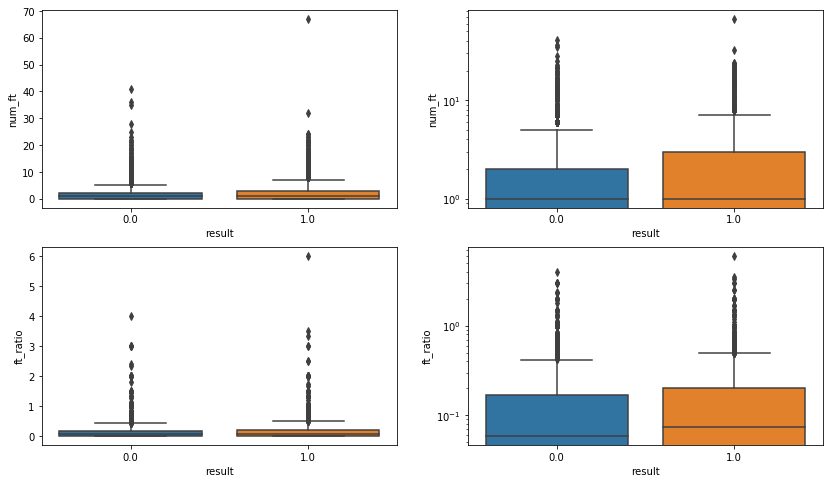

In [17]:
# Plot side by side boxplots 
fig, axes = plt.subplots(2,2,figsize=(14,8))
for idx1, var in enumerate(['num_ft','ft_ratio']):
    for idx2 in range(0,2):
        if idx2 == 0:
            sns.boxplot(x='result', y=var, data=sea_train, ax=axes[idx1,idx2])
        else:
            sns.boxplot(x='result', y=var, data=sea_train, ax=axes[idx1,idx2])
            ax=axes[idx1,idx2].set(yscale='log')

Below, I defined some helpers for custom binning and plotting. 

In [18]:
def quant_bin(df, to_bin, to_agg, quantiles=[0.0, 0.25, 0.5, 0.75, 1.0]):
    '''Bin and agg one series in a df by another using quantiles
    
    This favors even number of samples per bin over even spacing.
    '''
    columns = ['bin_mean', 'bin_bounds', 'mean', 'median', 'stdev', 'bin_count']
    results = [[],[],[],[],[],[]]
    
    for i in range(1, len(quantiles)):
        lwr = df[to_bin].quantile(quantiles[i-1])
        upr = df[to_bin].quantile(quantiles[i])
        sub_df = df.loc[(df[to_bin] >= lwr) & (df[to_bin] < upr)]
        results[0].append((lwr+upr)/2)
        results[1].append((lwr,upr))
        results[2].append(sub_df[to_agg].mean())
        results[3].append(sub_df[to_agg].median())
        results[4].append(sub_df[to_agg].std())
        results[5].append(sub_df.shape[0])
        
    return dict(zip(columns,results))      

In [19]:
def even_bin(df, to_bin, to_agg, num_bins=5):
    '''Bin and agg one series in a df by another using evenly spaced bins
    
    This favors even spacing of bins over even number of samples
    '''
    columns = ['bin_mean', 'bin_bounds', 'mean', 'median', 'stdev', 'bin_count']
    results = [[],[],[],[],[],[]]
    
    # Compute bin ends
    intv = df[to_bin].max() / float(num_bins)
    bin_edges = [i*intv for i in range(num_bins+1)]
    
    for i in range(1, len(bin_edges)):
        lwr = bin_edges[i-1]
        upr = bin_edges[i]
        sub_df = df.loc[(df[to_bin] >= lwr) & (df[to_bin] < upr)]
        results[0].append((lwr+upr)/2)
        results[1].append((lwr,upr))
        results[2].append(sub_df[to_agg].mean())
        results[3].append(sub_df[to_agg].median())
        results[4].append(sub_df[to_agg].std())
        results[5].append(sub_df.shape[0])
        
    return dict(zip(columns,results))  

In [20]:
def plot_bins(results, agg='mean', xlab='', ylab='', title='', bin_count=False):
    
    fig, ax = plt.subplots()
    
    results = pd.DataFrame(results)
    results = results.loc[results['bin_count'] != 0]
    
    if agg == 'mean':
        ax.errorbar(results['bin_mean'], results['mean'], results['stdev'], color='#1b9e77')
    else:
        ax.plot(results['median'], color='#1b9e77')
    ax.set_xlabel(xlab)
    ax.set_ylabel(ylab, color='#1b9e77')
    ax.set_title(title)
    
    if bin_count:
        ax2 = ax.twinx()
        ax2.plot(results['bin_mean'], results['bin_count'], color='#7570b3')
        ax2.set_ylabel('Number of Samples / Bin', color='#7570b3')

Now, I'll look at mean number of focused text tokens binned by number of reviews.

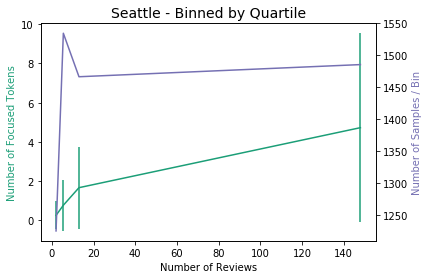

In [21]:
# For Seattle
sea_ft_bin_q = quant_bin(sea_train, 'num_reviews', 'num_ft')
plot_bins(sea_ft_bin_q, agg='mean', xlab='Number of Reviews', ylab='Number of Focused Tokens', bin_count=True,
          title='Seattle - Binned by Quartile')

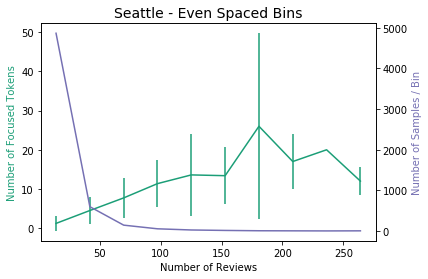

In [22]:
# For Seattle
sea_ft_bin_e = even_bin(sea_train, 'num_reviews', 'num_ft', num_bins=10)
plot_bins(sea_ft_bin_e, agg='mean', xlab='Number of Reviews', ylab='Number of Focused Tokens', bin_count=True,
          title='Seattle - Even Spaced Bins')

Now, I'll also look at mean failure rate binned by number of focused tokens.

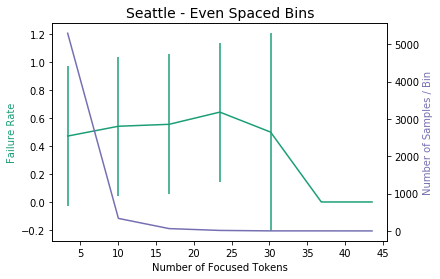

In [23]:
# For Seattle
sea_ft_bin_e = even_bin(sea_train, 'num_ft', 'result', num_bins=10)
plot_bins(sea_ft_bin_e, agg='mean', xlab='Number of Focused Tokens', ylab='Failure Rate', bin_count=True,
          title='Seattle - Even Spaced Bins')

Now, I'll also look at mean failure rate binned by focused text ratio.

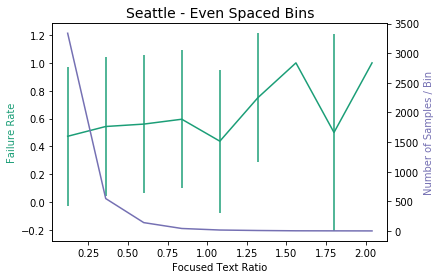

In [24]:
# For Seattle
sea_ft_bin_e = even_bin(sea_train.loc[sea_train.num_reviews > 3], 'ft_ratio', 'result', num_bins=10)
plot_bins(sea_ft_bin_e, agg='mean', xlab='Focused Text Ratio', ylab='Failure Rate', bin_count=True,
          title='Seattle - Even Spaced Bins')

It looks like both number of focused tokens and ft_ratio have a positive correlation with failure rate, up until the point where the sample size becomes very small (likely just noise at that point).

### Exploring Predictivess of Individual Focused Tokens

I will evaluate the individual focused tokens using three approaches: cross-tabulation/conditional distributions, Chi2 test (univariate, linear), and Random Forest (greedy but can capture interactions, nonlinear).

Both Chi2 and RF will favor more common focused tokens, while cross-tabulation will look at the empircal distribution of failures conditional on each focused token. 

I will start with the cross-tabulation (or really just a summarized format of 'word, conditional failure rate, support'.

In [25]:
word2idx = {}
words = []
occurences = []
failures = []

for idx, row in sea_train.iterrows():
    if row.focus_text != 'unk':
        ft = row.focus_text.split()
        for token in ft:
            if token in word2idx:
                idx = word2idx[token]
            else:
                idx = len(words)
                words.append(token)
                occurences.append(0)
                failures.append(0)
                word2idx[token] = idx
            occurences[idx] += 1
            if row.result == 0:
                failures[idx] += 1
            
summary = [(w, o, f/o) for w, o, f in zip(words, occurences, failures)]
summary.sort(reverse=True, key = lambda x: x[2])

print('word, number of occurences, conditional failure rate, lift over expected (ratio)')
for tup in summary:
    print(f'{tup[0]}, {tup[1]}, {tup[2]:.2f}, {tup[2]/sea_train.result.mean():.2f}')

word, number of occurences, conditional failure rate, lift over expected (ratio)
contaminated, 1, 1.00, 2.10
feces, 7, 0.86, 1.80
stomachache, 13, 0.85, 1.77
jail, 9, 0.78, 1.63
indigestion, 13, 0.77, 1.61
rumbling, 16, 0.75, 1.57
crud, 4, 0.75, 1.57
meth, 19, 0.74, 1.55
inspection, 14, 0.71, 1.50
flu, 20, 0.70, 1.47
unsanitary, 26, 0.69, 1.45
fingernails, 6, 0.67, 1.40
mobster, 6, 0.67, 1.40
peed, 6, 0.67, 1.40
trashy, 31, 0.65, 1.35
unclean, 11, 0.64, 1.33
marred, 11, 0.64, 1.33
beards, 11, 0.64, 1.33
poop, 32, 0.62, 1.31
worm, 16, 0.62, 1.31
junk, 89, 0.62, 1.30
ammonia, 13, 0.62, 1.29
violently, 13, 0.62, 1.29
queasy, 18, 0.61, 1.28
scum, 10, 0.60, 1.26
unhealthy, 80, 0.60, 1.26
rug, 10, 0.60, 1.26
slimy, 94, 0.57, 1.20
sickeningly, 14, 0.57, 1.20
horrifying, 23, 0.57, 1.19
sneeze, 18, 0.56, 1.17
repulsive, 11, 0.55, 1.14
sanitary, 39, 0.54, 1.13
rat, 134, 0.54, 1.13
recycled, 28, 0.54, 1.12
urine, 19, 0.53, 1.10
cigarette, 59, 0.53, 1.10
chemical, 44, 0.52, 1.10
raw, 780, 0.52, 1.

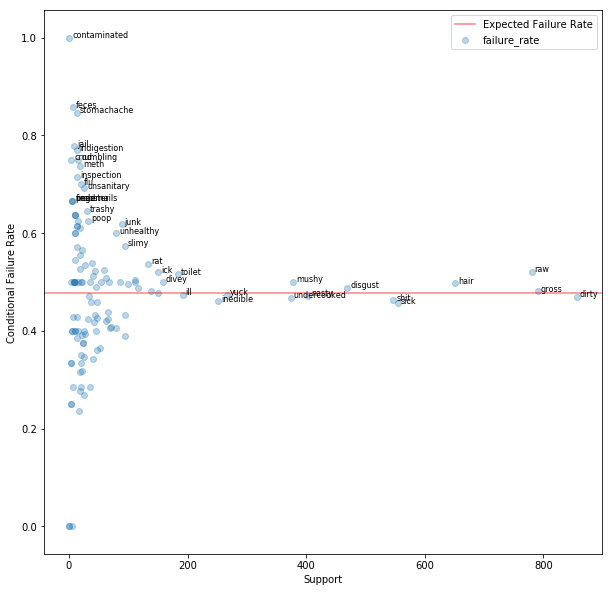

In [26]:
# Compare failure rate and number of occurences
temp_df = pd.DataFrame({'word':words,
                        'occurences':occurences,
                        'failures':failures})
temp_df['failure_rate'] = temp_df['failures'] / temp_df['occurences']
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(temp_df['occurences'], temp_df['failure_rate'], alpha=0.3)
for idx, row in temp_df.iterrows():
     if row.failure_rate + (1/1000)*row.occurences > 0.65:
            ax.text(row.occurences + 5, row.failure_rate, row.word, fontdict={'fontsize':8})
ax.axhline(y=sea_train['result'].mean(), color='r', alpha=0.5, label='Expected Failure Rate')
ax.set_xlabel('Support')
ax.set_ylabel('Conditional Failure Rate')
ax.legend()
plt.show()

For most of the words (with support below 100), it's not obvious that the higher conditional probabilities are real as opposed to chance (note the rough symmetry above and below the expected failure rate at lower support values). There might be a slightly higher density on the higher failure rate side. 

It does look like there is a pattern in the words falling between 100 and 200 support (note 'junk', 'unhealthy', 'slimy', 'rat', 'ick', 'toilet', 'divey'). I have down-selected to words that are expected to have a positive correlation with failures, and there is no mirrored outward bow on the lower side of the line. 

In addition, it looks like raw is a good predictor. That makes intuitive sense as I would expect that restaurants serving raw food have more complex and failure-prone handling requirements. 

Now, I will move on to evaluating the focused tokens using Chi2 and Random Forest feature importance.

In [27]:
from sklearn.feature_selection import chi2
from sklearn.ensemble import RandomForestClassifier

In [28]:
sea_cvect = CountVectorizer(binary=True)
sea_ft_counts = sea_cvect.fit_transform(sea_train.focus_text)
sea_labeled_counts = dict(zip(pd.Series(sea_cvect.vocabulary_).sort_values().index.values, np.mean(np.array(sea_ft_counts.todense()), axis=0)))

Largest Correlations
peeing: 7.044928706886429
unk: 6.5716415228923
dirty: 6.219847162567849
hygiene: 5.532769411033106
disturbing: 5.49776729894647
grime: 5.428360570479238
cockroach: 5.056031182122521
stomachache: 4.626705663802637
pesticides: 4.389276533235401
sprayed: 4.346096188183043


Smallest Correlations
chemical: 6.237753185883702e-05
urine: 0.000739012127007618
sickly: 0.008310882316141832
filthy: 0.008527751667927345
unkept: 0.008631047632813034
artery: 0.011151136206333106
sickeningly: 0.012136353922521725
ick: 0.013470837959474012
irresponsible: 0.017262095265626068
ammonia: 0.017262095265626068


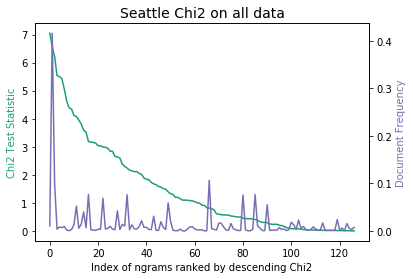

In [29]:
# First, using all of the Seattle data with Chi2
N=10 # Number of words to print
counts_chi2 = chi2(sea_ft_counts, sea_train['result'].values)

indices = np.argsort(counts_chi2[0])
feature_names = np.array(sea_cvect.get_feature_names())[indices]
feature_corrs = np.array(counts_chi2[0][indices])

print("Largest Correlations")
for i in range(1,N+1):
    print(feature_names[-i] + ': ' + str(feature_corrs[-i]))
    
print('\n')
    
indices = np.argsort(-1*counts_chi2[0])
feature_names = np.array(sea_cvect.get_feature_names())[indices]
feature_corrs = np.array(counts_chi2[0][indices])

print("Smallest Correlations")
for i in range(1,N+1):
    print(feature_names[-i] + ': ' + str(feature_corrs[-i]))
    
indices = np.argsort(-1*counts_chi2[0])
feature_names = np.array(sea_cvect.get_feature_names())[indices]
feature_corrs = np.array(counts_chi2[0][indices])
feature_counts = np.mean(np.array(sea_ft_counts.todense()), axis=0)[indices]

fig, ax = plt.subplots()

ax.plot(feature_corrs, color='#1b9e77')
ax.set_xlabel('Index of ngrams ranked by descending Chi2')
ax.set_ylabel('Chi2 Test Statistic', color='#1b9e77')
ax.set_title('Seattle Chi2 on all data')

ax2 = ax.twinx()
ax2.plot(feature_counts, color='#7570b3')
ax2.set_ylabel('Document Frequency', color='#7570b3')

plt.show()

Largest Correlations
gross: 0.04226394880760321
hair: 0.036927575879040636
raw: 0.034733315539773754
shit: 0.03341438132707138
sick: 0.03298617118696663
dirty: 0.032402649105488394
nasty: 0.028954442994614086
disgust: 0.026964159545315006
mushy: 0.025684369960506784
yuck: 0.022398099645152478


Smallest Correlations
contaminated: 0.00021942403138283957
vacuums: 0.00022094946439332107
bushes: 0.0005911463117366059
unkept: 0.0008464890873149399
tarnished: 0.0008988475507846286
bacteria: 0.0009867016632189335
pesticides: 0.0012620621255641673
uneatable: 0.0013542280814273205
gunk: 0.0013733160846077723
seagull: 0.0014152185186316417


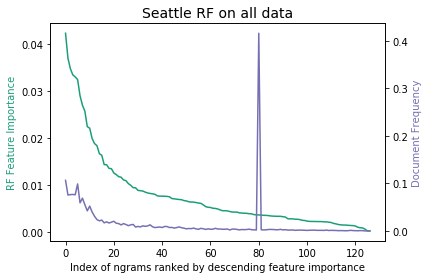

In [30]:
# Next, look at the Seattle data with a Random Forest
N=10 # Number of words to print

sea_rf_fi = RandomForestClassifier(n_estimators=100)
sea_rf_fi.fit(sea_ft_counts, sea_train['result'].values)

indices = np.argsort(sea_rf_fi.feature_importances_)
feature_names = np.array(sea_cvect.get_feature_names())[indices]
feature_imp = np.array(sea_rf_fi.feature_importances_[indices])

print("Largest Correlations")
for i in range(1,N+1):
    print(feature_names[-i] + ': ' + str(feature_imp[-i]))
    
print('\n')
    
indices = np.argsort(-1*sea_rf_fi.feature_importances_)
feature_names = np.array(sea_cvect.get_feature_names())[indices]
feature_imp = np.array(sea_rf_fi.feature_importances_[indices])

print("Smallest Correlations")
for i in range(1,N+1):
    print(feature_names[-i] + ': ' + str(feature_imp[-i]))
    
indices = np.argsort(-1*sea_rf_fi.feature_importances_)
feature_names = np.array(sea_cvect.get_feature_names())[indices]
feature_imp = np.array(sea_rf_fi.feature_importances_[indices])
feature_counts = np.mean(np.array(sea_ft_counts.todense()), axis=0)[indices]

fig, ax = plt.subplots()

ax.plot(feature_imp, color='#1b9e77')
ax.set_xlabel('Index of ngrams ranked by descending feature importance')
ax.set_ylabel('RF Feature Importance', color='#1b9e77')
ax.set_title('Seattle RF on all data')

ax2 = ax.twinx()
ax2.plot(feature_counts, color='#7570b3')
ax2.set_ylabel('Document Frequency', color='#7570b3')

plt.show()

In general, the random forest is more biased towards more frequently occuring features than the Chi2 statistic. 

Now, I will compare the two approaches for agreement/disagreement. The size of the points below represents the relative value of the support for a given word.

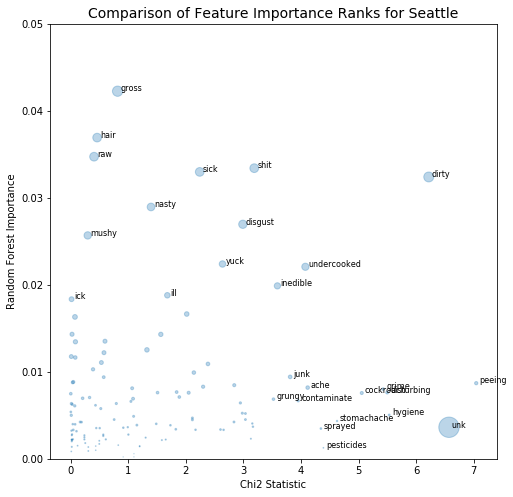

In [31]:
sea_ft_df = pd.DataFrame({'ngram':sea_cvect.get_feature_names(),
                          'df':np.mean(np.array(sea_ft_counts.todense()), axis=0),
                          'chi2':counts_chi2[0],
                          'rf_fimp':sea_rf_fi.feature_importances_})
fig, ax = plt.subplots(figsize=(8,8))
ax.scatter(sea_ft_df['chi2'], sea_ft_df['rf_fimp'], s=1000*sea_ft_df['df'], alpha=0.3)
for idx, row in sea_ft_df.iterrows():
    if (row.chi2 > 3.5) or (row.rf_fimp > 0.018):
        ax.text(row.chi2 + 0.05, row.rf_fimp, row.ngram, fontdict={'fontsize':8})
ax.set_ylim(0,0.05)
ax.set_xlabel('Chi2 Statistic')
ax.set_ylabel('Random Forest Importance')
ax.set_title('Comparison of Feature Importance Ranks for Seattle')
plt.show()

Interestingly enough, dirty stands out on both measures but actually has a conditional failure rate that is slightly lower than that expected across the entire training set. If I roughly bisect the graph from top-left to bottom-right I get the following words: gross, shit, disgust, undercooked, disturbing, peeing, unk, dirty

In [32]:
top_words = {'gross', 'shit', 'disgust', 'undercooked', 'disturbing', 'peeing', 'unk', 'dirty'}
temp_df.loc[temp_df['word'].apply(lambda x: x in top_words)].head()

,word,occurences,failures,failure_rate
2,shit,547,253,0.462523
3,dirty,856,402,0.469626
6,disgust,469,229,0.488273
9,disturbing,52,19,0.365385
10,peeing,71,29,0.408451


These words don't even have an elevated failure rate. 